In [2]:
from torch import nn
import torch.nn.functional as F
import torch

class BN_Conv2d(nn.Module):
    """
    BN_CONV_RELU
    """

    def __init__(self, in_channels: object, out_channels: object, kernel_size: object, stride: object, padding: object,
                 dilation=1, groups=1, bias=False) -> object:
        super(BN_Conv2d, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride,
                      padding=padding, dilation=dilation, groups=groups, bias=bias),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return F.relu(self.seq(x))

class DenseBlock(nn.Module):

    def __init__(self, input_channels, num_layers, growth_rate):
        super(DenseBlock, self).__init__()
        self.num_layers = num_layers
        self.k0 = input_channels
        self.k = growth_rate
        self.layers = self.__make_layers()

    def __make_layers(self):
        layer_list = []
        for i in range(self.num_layers):
            layer_list.append(nn.Sequential(
                BN_Conv2d(self.k0+i*self.k, 4*self.k, 1, 1, 0),
                BN_Conv2d(4 * self.k, self.k, 3, 1, 1)
            ))
        return layer_list

    def forward(self, x):
        feature = self.layers[0](x)
        out = torch.cat((x, feature), 1)
        for i in range(1, len(self.layers)):
            feature = self.layers[i](out)
            out = torch.cat((feature, out), 1)
        return out

    
class DenseNet(nn.Module):

    def __init__(self, layers: object, k, theta, num_classes) -> object:
        super(DenseNet, self).__init__()
        # params
        self.layers = layers
        self.k = k
        self.theta = theta
        # layers
        self.conv = BN_Conv2d(3, 2*k, 7, 2, 3)
        self.blocks, patches = self.__make_blocks(2*k)
        self.fc = nn.Linear(patches, num_classes)

    def __make_transition(self, in_chls):
        out_chls = int(self.theta*in_chls)
        return nn.Sequential(
            BN_Conv2d(in_chls, out_chls, 1, 1, 0),
            nn.AvgPool2d(2)
        ), out_chls

    def __make_blocks(self, k0):
        """
        make block-transition structures
        :param k0:
        :return:
        """
        layers_list = []
        patches = 0
        for i in range(len(self.layers)):
            layers_list.append(DenseBlock(k0, self.layers[i], self.k))
            patches = k0+self.layers[i]*self.k      # output feature patches from Dense Block
            if i != len(self.layers)-1:
                transition, k0 = self.__make_transition(patches)
                layers_list.append(transition)
        return nn.Sequential(*layers_list), patches

    def forward(self, x):
        out = self.conv(x)
        out = F.max_pool2d(out, 3, 2, 1)
        # print(out.shape)
        out = self.blocks(out)
        # print(out.shape)
        out = F.avg_pool2d(out, 7)
        # print(out.shape)
        out = out.view(out.size(0), -1)
        out = F.softmax(self.fc(out))
        return out


train loss 0.011, train acc 0.996
5.0 examples/sec on [device(type='cpu')]
start pre
pre 2
end


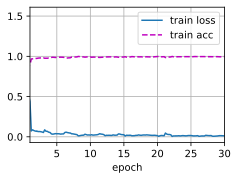

In [3]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import numpy as np
from model import *
from torchvision.models import densenet

demo = False

data_dir = './data/emoji/'

def read_csv_labels(fname):
    """读取fname来给标签字典返回一个文件名"""
    with open(fname, 'r') as f:
        # 跳过文件头行(列名)
        lines = f.readlines()[1:]

    tokens = [l.rstrip().split(',') for l in lines]
    tokens = np.delete(tokens,[2,3,4,5,6,7,8,9,10,11],axis=1)

    return dict(((name.split('.')[0], label) for name, label in tokens))

def reorg_dog_data(data_dir, valid_ratio):
    labels = read_csv_labels(os.path.join(data_dir, 'train.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)
    print('# 训练样本 :', len(labels))
    print('# 类别 :', len(set(labels.values())))

batch_size = 32
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)

transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224x224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0/4.0, 4.0/3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4,
                                       contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

train_ds, train_valid_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [torchvision.datasets.ImageFolder(
    os.path.join(data_dir, 'train_valid_test', folder),
    transform=transform_test) for folder in ['valid', 'test']]

train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)
print("start train")

loss = nn.CrossEntropyLoss(reduction="none")

devices, num_epochs, lr, wd = d2l.try_all_gpus(), 30, 2e-4, 5e-4
lr_period, lr_decay, net = 4, 0.9, torchvision.models.densenet121(pretrained=True, progress=True)

def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
    trainer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                              weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss', 'train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(net, features, labels,
                                          loss, trainer, devices)
            metric.add(l, acc, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))
        if valid_iter is not None:
            valid_acc = d2l.evaluate_accuracy_gpu(net, valid_iter)
            animator.add(epoch + 1, (None, None, valid_acc))
        scheduler.step()
    measures = (f'train loss {metric[0] / metric[2]:.3f}, '
                f'train acc {metric[1] / metric[2]:.3f}')
    if valid_iter is not None:
        measures += f', valid acc {valid_acc:.3f}'
    print(measures + f'\n{metric[2] * num_epochs / timer.sum():.1f}'
                     f' examples/sec on {str(devices)}')


net, preds = torchvision.models.densenet121(pretrained=True, progress=True), []

train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,
      lr_decay)

print("start pre")
for X, _ in test_iter:
    y_hat = net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())

print ("pre 2")
sorted_ids = []
for value in range(3000, len(test_ds) + 3000):
    imgid = str(value) + ".jpg"
    sorted_ids.append(imgid)

df = pd.DataFrame({'image_id': sorted_ids, 'is_male': preds})
df['is_male'] = df['is_male'].apply(lambda x: train_valid_ds.classes[x])
df.to_csv('submission.csv', index=False)
print("end")